In [1]:
from create_profiles import load_data
import random
import operator

def print_profile(profile):
    for country, ballot in profile.items():
        print(f"{country}: {ballot}")

In [3]:
profiles_per_edition = load_data()

In [4]:
def get_all_alternatives(profile):
    return set(list(profile.values())[0]).union(set(list(profile.values())[1]))

def random_dictatorship(profile):
    chosen_agent = random.choice(list(profile.keys()))
    return profile[chosen_agent][0]

def stv_with_random_dictatorship(profile):
    remaining_countries = get_all_alternatives(profile)

    while(len(remaining_countries) > 1):
        chosen_agent = random.choice(list(profile.keys()))
        for country in reversed(profile[chosen_agent]):
            if country in remaining_countries:
                remaining_countries.remove(country)
                break
    
    return remaining_countries.pop()

def scoring_social_choice_function(profile, scoring_system):
    points_hist = {country: 0 for country in get_all_alternatives(profile)}
    for ballot in profile.values():
        for to_country, points in zip(ballot, scoring_system):
            points_hist[to_country] += points
    return max(points_hist.items(), key=operator.itemgetter(1))[0]

def song_festival_rules(profile):
    scoring_system = [12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
    return scoring_social_choice_function(profile, scoring_system)

def borda(profile):
    scoring_system = list(reversed(range(len(profile) - 1)))
    return scoring_social_choice_function(profile, scoring_system)

def plurality(profile):
    scoring_system = [1]
    return scoring_social_choice_function(profile, scoring_system)

all_scfs = [random_dictatorship, stv_with_random_dictatorship, plurality, borda, song_festival_rules]
all_scf_names = [scf.__name__ for scf in all_scfs]
all_scfs_with_names = list(zip(all_scfs, all_scf_names))

In [14]:
def add_linear_cost(profile):
    """
    profile: a dict representing the profile of the form {agent: [choice_1, ... , choice_n]}
    returns: a dict of the form: {agent: [(choice_1, 0), ... , (choice_n, n-1)]}
    """
    return {agent: list(zip(ballot, range(len(ballot)))) for agent, ballot in profile.items()}

def get_total_cost_for_alternative(alternative, profile_with_costs):
        cost = 0
        for agent, ballot_with_costs in profile_with_costs.items():
            alternative_cost_dict = dict(ballot_with_costs)
            if alternative in alternative_cost_dict:
                cost += alternative_cost_dict[alternative]
        return cost

def get_lowest_cost(alternatives, profile_with_costs):
    lowest_cost = 99999
    best_a = None
    for a in alternatives:
        cost = get_total_cost_for_alternative(a, profile_with_costs)
        if cost < lowest_cost:
            best_a = a
            lowest_cost = cost
    return lowest_cost, best_a


def distortion(chosen_alternative, profile):
    alternatives = get_all_alternatives(profile)
    if chosen_alternative not in alternatives:
        raise KeyError("The chosen alternative is not in the provided profile")
    profile_with_costs = add_linear_cost(profile)
    
    best_possible_cost, best_a = get_lowest_cost(alternatives, profile_with_costs)
    chosen_alternative_cost = get_total_cost_for_alternative(chosen_alternative, profile_with_costs)
#     print(f"Chosen a: {chosen_alternative}({chosen_alternative_cost})\nBest a: {best_a}({best_possible_cost})")
    return chosen_alternative_cost / best_possible_cost

def best_scf(profile, measure=distortion, low_is_good=True):
    scf_measure_pairs = [(scf_name, measure(scf(profile), profile)) for scf, scf_name in all_scfs_with_names]    
    return list(sorted(scf_measure_pairs, key=lambda p: p[1], reverse=(not low_is_good)))

def summed_ranks(chosen_alternative, profile):
    sum_of_ranks = 0
    for ballot in profile.values():
        for rank, alternative in zip(range(20), ballot):
            if alternative == chosen_alternative:
                sum_of_ranks += rank
    return sum_of_ranks

def min_rank(chosen_alternative, profile):
    lowest_rank_of_chosen_alternative_rank = 0
    for ballot in profile.values():
        for rank, alternative in zip(range(20), ballot):
            if alternative == chosen_alternative and rank > lowest_rank_of_chosen_alternative_rank:
                lowest_rank_of_chosen_alternative_rank = rank
    return lowest_rank_of_chosen_alternative_rank

In [41]:
def aggregate_best_scf_for_all_profiles(measure):
    scf_hist = {scf_name: 0 for scf_name in all_scf_names}
    for edition, profile in profiles_per_edition.items():
        ordered_scfs = best_scf(profile, measure)
        best_scfs = [scf_name for scf_name, measured_score in ordered_scfs if measured_score == ordered_scfs[0][1]]
        for scf in best_scfs:
            scf_hist[scf] += 1
    return sorted(scf_hist.items(), key=lambda p: p[1], reverse=True)

def run_aggregate_n_times(measure, n):
    scf_hist = dict(aggregate_best_scf_for_all_profiles(measure))
    for _ in range(n - 1):
        for scf, times_it_was_the_best in aggregate_best_scf_for_all_profiles(measure):
            scf_hist[scf] += times_it_was_the_best
    return sorted(scf_hist.items(), key=lambda p: p[0], reverse=True)

In [68]:
n = 1000

min_rank_results = run_aggregate_n_times(min_rank, n)
print(f"Min rank: {min_rank_results}")

distortion_results = run_aggregate_n_times(distortion, n)
print(f"Distortion: {distortion_results}")

summed_rank_results = run_aggregate_n_times(summed_ranks, n)
print(f"Summed ranks: {summed_rank_results}")

Min rank: [('stv_with_random_dictatorship', 44594), ('song_festival_rules', 44685), ('random_dictatorship', 28312), ('plurality', 46455), ('borda', 47663)]
Distortion: [('stv_with_random_dictatorship', 31586), ('song_festival_rules', 65000), ('random_dictatorship', 19171), ('plurality', 47000), ('borda', 72000)]
Summed ranks: [('stv_with_random_dictatorship', 27447), ('song_festival_rules', 58283), ('random_dictatorship', 25388), ('plurality', 48671), ('borda', 60595)]


<IPython.core.display.Javascript object>


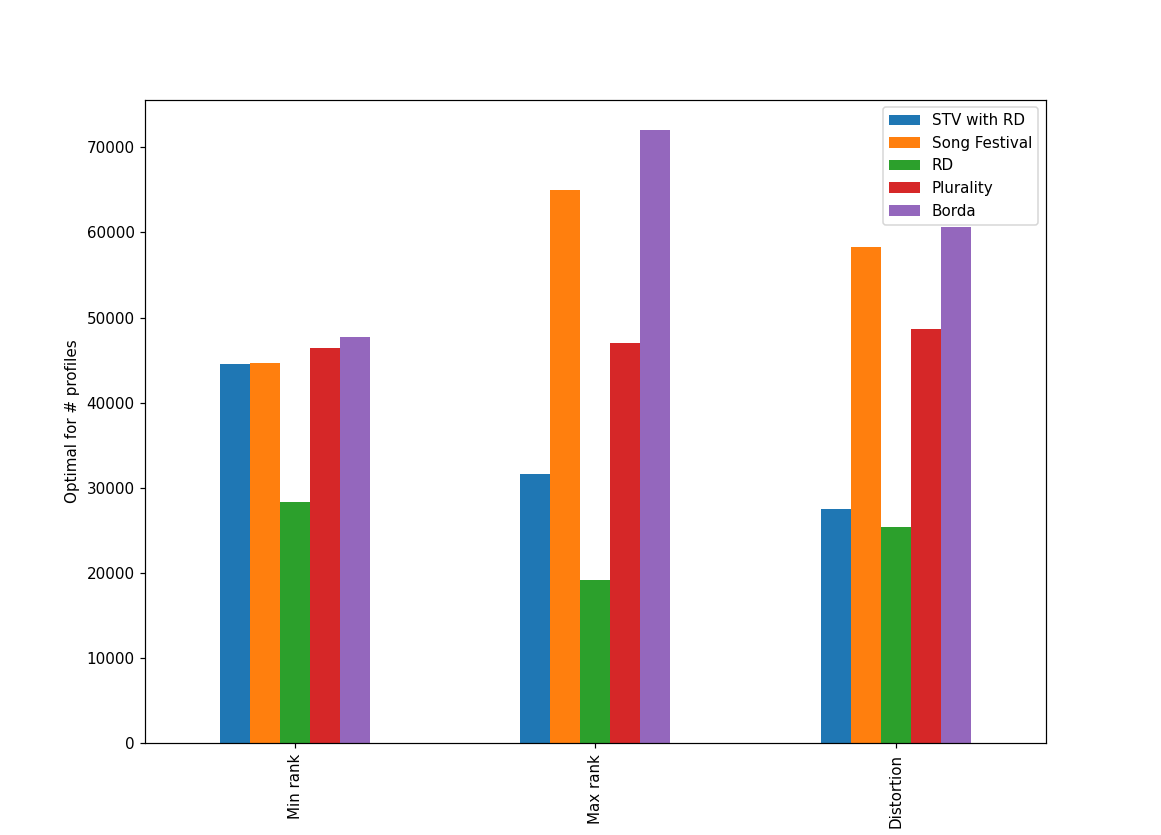

In [69]:
%matplotlib notebook
import pandas as pd
X = ['Min rank', 'Max rank', 'Distortion']
min_r = list(dict(min_rank_results).values())
max_r = list(dict(distortion_results).values())
dist = list(dict(summed_rank_results).values())

columns = ['STV with RD', 'Song Festival', 'RD', 'Plurality', 'Borda']
df = pd.DataFrame(np.array([min_r,max_r,dist]), index=X, columns=columns)
df.plot.bar()
plt.ylabel('Optimal for # profiles')

plt.show()

In [25]:
profile = profiles_per_edition['1975f']

# print_profile(profiles_per_edition['1975f'])

# print(distortion('United Kingdom', profile))
# print(distortion('The Netherlands', profile))
# print(summed_ranks('United Kingdom', profile))
# print(summed_ranks('The Netherlands', profile))
# print(min_rank('United Kingdom', profile))
# print(min_rank('The Netherlands', profile))

# Output:
# Min rank: [('borda', 40), ('plurality', 39), ('song_festival_rules', 37), ('stv_with_random_dictatorship', 24), ('random_dictatorship', 1)]
# Distortion: [('borda', 72), ('song_festival_rules', 65), ('plurality', 46), ('random_dictatorship', 0), ('stv_with_random_dictatorship', 0)]
# Summed ranks: [('borda', 64), ('song_festival_rules', 61), ('plurality', 51), ('random_dictatorship', 2), ('stv_with_random_dictatorship', 0)]

# print(f"Min rank: {aggregate_best_scf_for_all_profiles(min_rank)}")
# print(f"Distortion: {aggregate_best_scf_for_all_profiles(distortion)}")
# print(f"Summed ranks: {aggregate_best_scf_for_all_profiles(summed_ranks)}")
# print(best_scf(profiles_per_edition[list(profiles_per_edition.keys())[0]], min_rank))

# print(len(profiles_per_edition))

Min rank: [('borda', 54), ('plurality', 52), ('song_festival_rules', 50), ('stv_with_random_dictatorship', 48), ('random_dictatorship', 24)]
Min rank: [('borda', 47829), ('plurality', 46565), ('song_festival_rules', 44750), ('stv_with_random_dictatorship', 44572), ('random_dictatorship', 28307)]


In [20]:
print(best_scf(profile))
print(best_scf(profile, min_rank))
print(best_scf(profile, summed_ranks))

[('random_dictatorship', 1.0), ('plurality', 1.0), ('borda', 1.0), ('song_festival_rules', 1.0), ('stv_with_random_dictatorship', 1.3953488372093024)]
[('plurality', 9), ('borda', 9), ('song_festival_rules', 9), ('random_dictatorship', 11), ('stv_with_random_dictatorship', 16)]
[('random_dictatorship', 43), ('stv_with_random_dictatorship', 43), ('plurality', 43), ('borda', 43), ('song_festival_rules', 43)]


In [17]:
def borda_measure(profile, chosen_alternative):
    '''To calculate the Borda measure for a function, first calculate chosen_alternative with the given function, 
    then plug it in in this function. '''
    borda_winner = borda(profile)
    scoring_system = list(reversed(range(len(profile) - 1)))
    points_hist = {country: 0 for country in get_all_alternatives(profile)}
    for ballot in profile.values():
        for to_country, points in zip(ballot, scoring_system):
            points_hist[to_country] += points
    borda_score_of_chosen_alternative = points_hist[chosen_alternative]
    borda_score_of_winner = points_hist[borda_winner]
    result = borda_score_of_chosen_alternative/borda_score_of_winner
    '''Eigenlijk zou het resultaat het minimum van bovenstaande over alle profiles moeten zijn, 
    maar er zijn 121.645.100.408.832.000‬ mogelijke profiles..'''
    return result

borda_measure(profile, 'Belgium')

0.5437262357414449